# Time Series Analysis (One To One)

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Covert the featured label into a discrete column value type, instead of continuous.
* Time Shift the provided datasets with varied 'lag' values.
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set.
* Perform feature selection on the agglomorated matrix, dropping redundant features and finding the  optimum number of features. (Multivariate analysis - through a wrapper approach)
* Feed dataset into a number of machine learning models

A One to One approach is opted for in this experiment. The following experiment is trained on a single past sequence (t-lag), and is used to train and later predict a single (t+lag) sequence. This experiment varies from the 'Many To Many Time Series' Experiment, due to using a single time sequence to train and predict upcoming observations.

Applicable links:
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Module Installation and Importing Libraries

https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.2
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.19.0
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


Using TensorFlow backend.


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
#
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=3 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
test_split=.2 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA'] # Denotes which label to use for time series experiments
#
# K-Means Config
n_clusters = 3
n_jobs = 4
init= 'k-means++'
random_state=0

### Read data from file into Pandas Dataframes

In [3]:
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_sysstat.csv'
# rep_hist_snapshot_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_snapshot.csv'
# rep_hist_sysmetric_summary_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_sysmetric_summary.csv'
# rep_hist_sysstat_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_sysstat.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)
#
print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [4]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)
#
print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))
#
# print(rep_hist_snapshot_df.groupby(['SNAP_ID']).count())
# print(rep_hist_sysmetric_summary_df.groupby(['SNAP_ID']).count())
# print(rep_hist_sysstat_df.groupby(['SNAP_ID']).count())
# print(len(rep_hist_snapshot_df['SNAP_ID'].unique()))
# print(len(rep_hist_sysmetric_summary_df['SNAP_ID'].unique()))
# print(len(rep_hist_sysstat_df['SNAP_ID'].unique()))
# print(rep_hist_sysmetric_summary_df.tail())
# print(rep_hist_sysstat_df.tail())

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (27, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (27, 163)
Table [REP_HIST_SYSSTAT] - (27, 1180)


### Dealing with Empty Values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND TIME PER SEC', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'CURRENT OS LOAD', 'DB BLOCK CHANGES PER USER CALL', 'DB BLOCK GETS PER USER CALL', 'DDL STATEMENTS PARALLELIZED PER SEC', 'DML STATEMENTS PARALLELIZED PER SEC', 'EXECUTIONS PER USER CALL', 'HOST CPU USAGE PER SEC', 'I/O MEGABYTES PER SECOND', 'I/O REQUESTS PER SECOND', 'LOGICAL READS PER USER CALL', 'PQ QC SESSION COUNT', 'PQ SLAVE SESSION COUNT', 'PX OPERATIONS NOT DOWNGRADED PER SEC', 'PHYSICAL READ BYTES PER SEC', 'PHYSICAL WRITE BYTES PER SEC', 'PHYSICAL WRITE IO REQUESTS PER SEC', 'QUERIES PARALLELIZED PER SEC', 'REPLAYED USER CALLS', 'RUN QUEUE PER SEC', 'SESSION COUNT', 'STREAMS POOL USAGE PERCENTAGE', 'TEMP SPACE USED', 'TOTAL PGA ALLOCATED

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [6]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(27, 1418)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLSEXE

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(27, 1418)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [8]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(27, 1418)


### Feature Selection

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [9]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(27, 1418)

Shape before changes: [(27, 1418)]
Shape after changes: [(27, 490)]
Dropped a total [928]

After flatline column drop:
(27, 490)

After additional column drop:
(27, 480)


## Visualizing Labels

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Histograms

A simple and commonly used plot to quickly check the distribution of a sample of data is the histogram.

In the histogram, the data is divided into a pre-specified number of groups called bins. The data is then sorted into each bin and the count of the number of observations in each bin is retained.

The plot shows the bins across the x-axis maintaining their ordinal relationship, and the count in each bin on the y-axis.

A sample of data has a Gaussian distribution of the histogram plot, showing the familiar bell shape.

### Quantile-Quantile Plot

Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

### Shapiro-Wilk Test

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

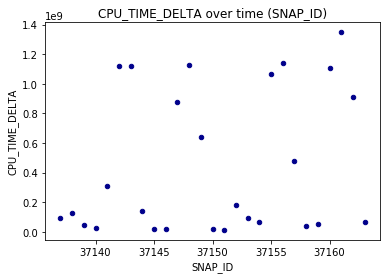

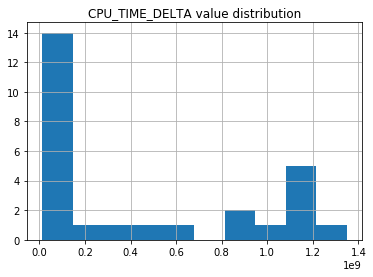

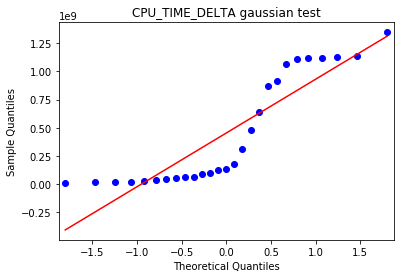

Statistics=0.783, p=0.000
Sample does not look Gaussian (reject H0)


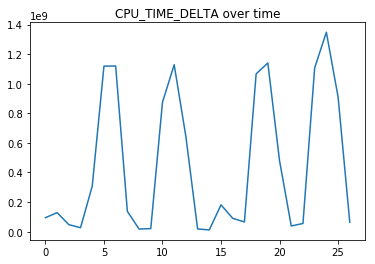

---------------------------------------------------------------


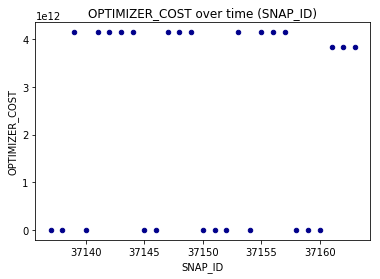

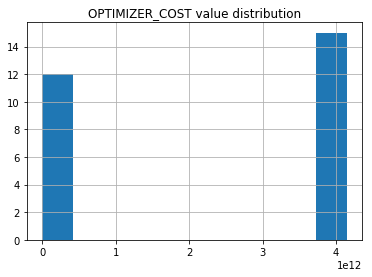

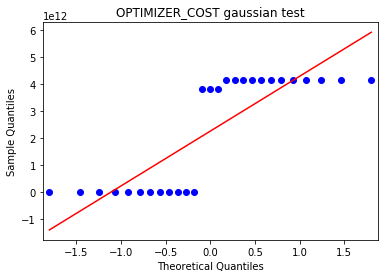

Statistics=0.653, p=0.000
Sample does not look Gaussian (reject H0)


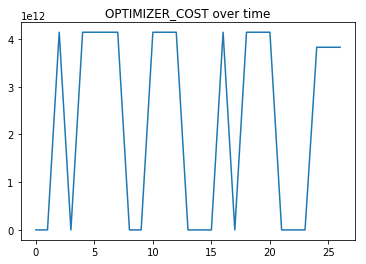

---------------------------------------------------------------


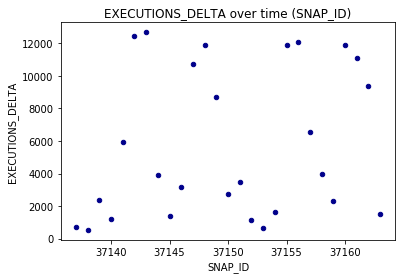

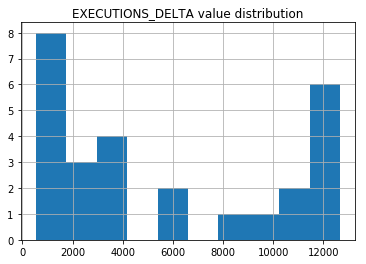

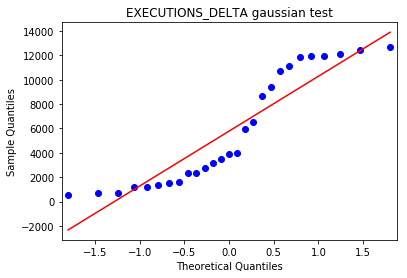

Statistics=0.842, p=0.001
Sample does not look Gaussian (reject H0)


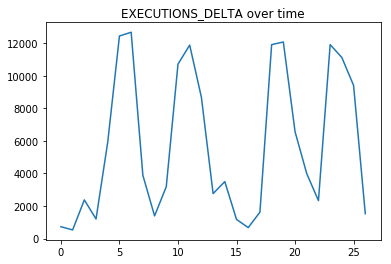

---------------------------------------------------------------


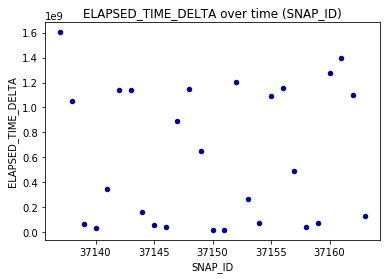

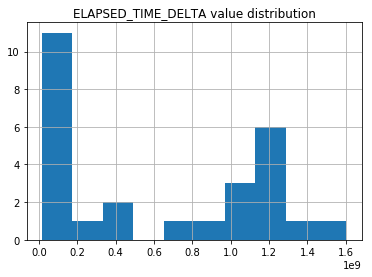

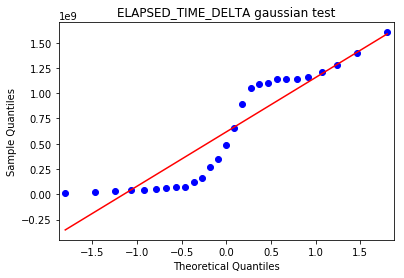

Statistics=0.841, p=0.001
Sample does not look Gaussian (reject H0)


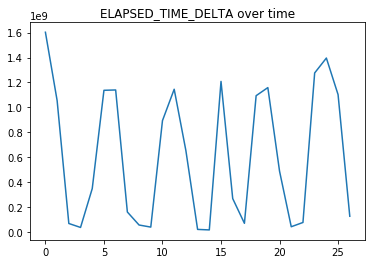

---------------------------------------------------------------


In [10]:
def shapiro_wilk(data):
    # normality test
    stat, p = sc.stats.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
#
for label in y_label:
    #
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    #
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    #
    qqplot(df[label], line='s')
    plt.title(label + ' gaussian test')
    plt.show()
    #
    shapiro_wilk(data=df[label])
    #
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [11]:
def get_outliers_std(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            # calculate summary statistics
            data_mean, data_std = df[header].mean(), df[header].std()
            # identify outliers
            cut_off = data_std * 3
            lower, upper = data_mean - cut_off, data_mean + cut_off
            #
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            #
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    #
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows
#
#Printing outliers to screen
outliers = get_outliers_std(df=df,
                            headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [0] outliers
EXECUTIONS_DELTA - [0] outliers
ELAPSED_TIME_DELTA - [0] outliers
Total Outliers: [0]

Label[CPU_TIME_DELTA] - Min[11829157] - Max[1347731695] - Mean[453333764.8518519] - Std[485987795.1315045]
Label[OPTIMIZER_COST] - Min[3788.0] - Max[4141638307776.0] - Mean[2265950020753.852] - Std[2067545690632.415]
Label[EXECUTIONS_DELTA] - Min[534.0] - Max[12670.0] - Mean[5785.037037037037] - Std[4581.4908178408605]
Label[ELAPSED_TIME_DELTA] - Min[15720310] - Max[1603233580] - Mean[617271113.1851852] - Std[548022166.7691759]

---------------------------------------------



### Outlier Detection - Interquartile Range Method

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution.

A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

Remember that percentiles can be calculated by sorting the observations and selecting values at specific indices. The 50th percentile is the middle value, or the average of the two middle values for an even number of examples. If we had 10,000 samples, then the 50th percentile would be the average of the 5000th and 5001st values.

We refer to the percentiles as quartiles (“quart” meaning 4) because the data is divided into four groups via the 25th, 50th and 75th values.

The IQR defines the middle 50% of the data, or the body of the data.

The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.

In [12]:
def get_outliers_quartile(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            q25, q75 = np.percentile(df[header], 25), np.percentile(df[header], 75)
            iqr = q75 - q25
            cut_off = iqr * .6 # This values needs to remain as it. It was found to be a good value so as to capture the relavent outlier data
            lower, upper = q25 - cut_off, q75 + cut_off
            #
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            #
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    #
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows
#
#Printing outliers to screen
outliers = get_outliers_quartile(df=df,
                                 headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [0] outliers
EXECUTIONS_DELTA - [0] outliers
ELAPSED_TIME_DELTA - [0] outliers
Total Outliers: [0]

Label[CPU_TIME_DELTA] - Min[11829157] - Max[1347731695] - Mean[453333764.8518519] - Std[485987795.1315045]
Label[OPTIMIZER_COST] - Min[3788.0] - Max[4141638307776.0] - Mean[2265950020753.852] - Std[2067545690632.415]
Label[EXECUTIONS_DELTA] - Min[534.0] - Max[12670.0] - Mean[5785.037037037037] - Std[4581.4908178408605]
Label[ELAPSED_TIME_DELTA] - Min[15720310] - Max[1603233580] - Mean[617271113.1851852] - Std[548022166.7691759]

---------------------------------------------



In [13]:
def edit_outliers(df=None, headers=None):
    """
    This method uses the interquartile method to edit all outliers to std.
    """
    outliers = get_outliers_quartile(df=df,
                                     headers=y_label)
    for label in y_label:
        min_val = df[label].min()
        max_val = df[label].max()
        mean_val = df[label].mean()
        std_val = df[label].std()
        #
        for i in range(len(outliers)):
            if label == outliers[i][0]:
                df[label].iloc[outliers[i][1]] = mean_val + std_val
                # print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
    return df
#
print("DF with outliers: " + str(df.shape))
df = edit_outliers(df=df,
                   headers=y_label)
print("DF with edited outliers: " + str(df.shape))

DF with outliers: (27, 480)
CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [0] outliers
EXECUTIONS_DELTA - [0] outliers
ELAPSED_TIME_DELTA - [0] outliers
DF with edited outliers: (27, 480)


### Data Normalization

Under the assumption that outliers have been capped/transformed, data is now passed through a min-max transformer.

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized_values = scaler.fit_transform(df.values)
#
df = pd.DataFrame(data=df_normalized_values, columns=df.columns)
del df_normalized_values
print(str(df.shape))
print(df.head())

(27, 480)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000    3.350606e-09      0.831383       0.000755       0.000000   
1  0.038462    3.586528e-08      0.819275       0.000000       0.062352   
2  0.076923    9.999997e-01      0.868839       0.999023       0.083548   
3  0.115385    1.224846e-07      0.842017       0.999047       0.034184   
4  0.153846    1.000000e+00      0.883846       0.997767       0.377956   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.011332                  0.021993     0.005718   
1                  0.000000                  0.000000     0.000000   
2                  0.997342                  0.179969     0.991189   
3                  0.994417                  0.073929     0.992579   
4                  0.984302                  0.476097     0.992289   

   SORTS_DELTA  EXECUTIONS_TOTAL                 ...                  \
0     0.636556          0.008853              

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [15]:
y_label.append('SNAP_ID')
y_df = df[y_label]
del y_label[-1]
df.drop(columns=y_label, inplace=True)
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(df.shape))
#
# Merging labels and features in respective order
df = pd.merge(y_df,df,on='SNAP_ID',sort=False,left_on=None, right_on=None)
print('Merged Labels + Vectors: ' + str(df.shape))
print(df.head())

Label ['CPU_TIME_DELTA', 'OPTIMIZER_COST', 'EXECUTIONS_DELTA', 'ELAPSED_TIME_DELTA'] shape: (27, 5)
Feature matrix shape: (27, 476)
Merged Labels + Vectors: (27, 480)
   CPU_TIME_DELTA  OPTIMIZER_COST  EXECUTIONS_DELTA  ELAPSED_TIME_DELTA  \
0        0.061809    3.350606e-09          0.016150            1.000000   
1        0.087509    3.586528e-08          0.000000            0.654414   
2        0.026595    9.999997e-01          0.151697            0.032488   
3        0.011288    1.224846e-07          0.055372            0.012530   
4        0.221439    1.000000e+00          0.444710            0.209174   

    SNAP_ID  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000      0.831383       0.000755       0.000000   
1  0.038462      0.819275       0.000000       0.062352   
2  0.076923      0.868839       0.999023       0.083548   
3  0.115385      0.842017       0.999047       0.034184   
4  0.153846      0.883846       0.997767       0.377956   

   END_OF_FETCH_COUNT_TOTAL

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #     for header in headers:
    #         if "(t)" in header:
    #             dropped_headers.append(header)
    #
    for i in range(1,n+1):
        for header in headers:
            if "(t+"+str(i)+")" in header:
                dropped_headers.append(str(header))
    #
    return df.drop(dropped_headers, axis=1)        
#
# Frame as supervised learning set
shifted_df = series_to_supervised(df, 0, lag)
#
# Seperate labels from features
y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df.drop(columns=y_df_column_names)
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\n:Labels')
print(y_df.columns)
print(y_df.shape)
#
# Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n=lag)
print('\n-------------\nFeatures After Time Shift')
print(X_df.columns)
print(X_df.shape)
# y_df = remove_n_time_steps(data=y_df, n=lag)
print('\n-------------\nLabels After Time Shift')
print(y_df.columns)
print(y_df.shape)


-------------
Features
Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)',
       ...
       'var471(t+3)', 'var472(t+3)', 'var473(t+3)', 'var474(t+3)',
       'var475(t+3)', 'var476(t+3)', 'var477(t+3)', 'var478(t+3)',
       'var479(t+3)', 'var480(t+3)'],
      dtype='object', length=1916)
(24, 1916)

-------------
:Labels
Index(['var1(t+3)', 'var2(t+3)', 'var3(t+3)', 'var4(t+3)'], dtype='object')
(24, 4)

-------------
Features After Time Shift
Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)',
       ...
       'var471(t)', 'var472(t)', 'var473(t)', 'var474(t)', 'var475(t)',
       'var476(t)', 'var477(t)', 'var478(t)', 'var479(t)', 'var480(t)'],
      dtype='object', length=480)
(24, 480)

-------------
Labels After Time Shift
Index(['var1(t+3)', 'var2(t+3)', 'var3(t+3)', 'var4(t+3)'], dtype='object')
(24, 4)


### Bucket Function

Takes a value and converts it into a bucket value (of 10 values)

In [17]:
def discretize_value(amount):
    """
    Assumes that amount is decimal value. If so, return 1st value after decimal.
    """
    amount = float(amount)
    if amount < 0:
        amount = 0.01
    if amount > 1:
        amount = 0.99
    amount = str(amount)
    amount = amount.split('.')
    amount = amount[1][0]
    return float(amount)
#print(discretize_value(amount=0.26))

### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(19, 480)] Type - <class 'numpy.ndarray'>
y_train shape [(19, 4)] Type - <class 'numpy.ndarray'>
X_validate shape [(2, 480)] Type - <class 'numpy.ndarray'>
y_validate shape [(2, 4)] Type - <class 'numpy.ndarray'>
X_test shape [(3, 480)] Type - <class 'numpy.ndarray'>
y_test shape [(3, 4)] Type - <class 'numpy.ndarray'>


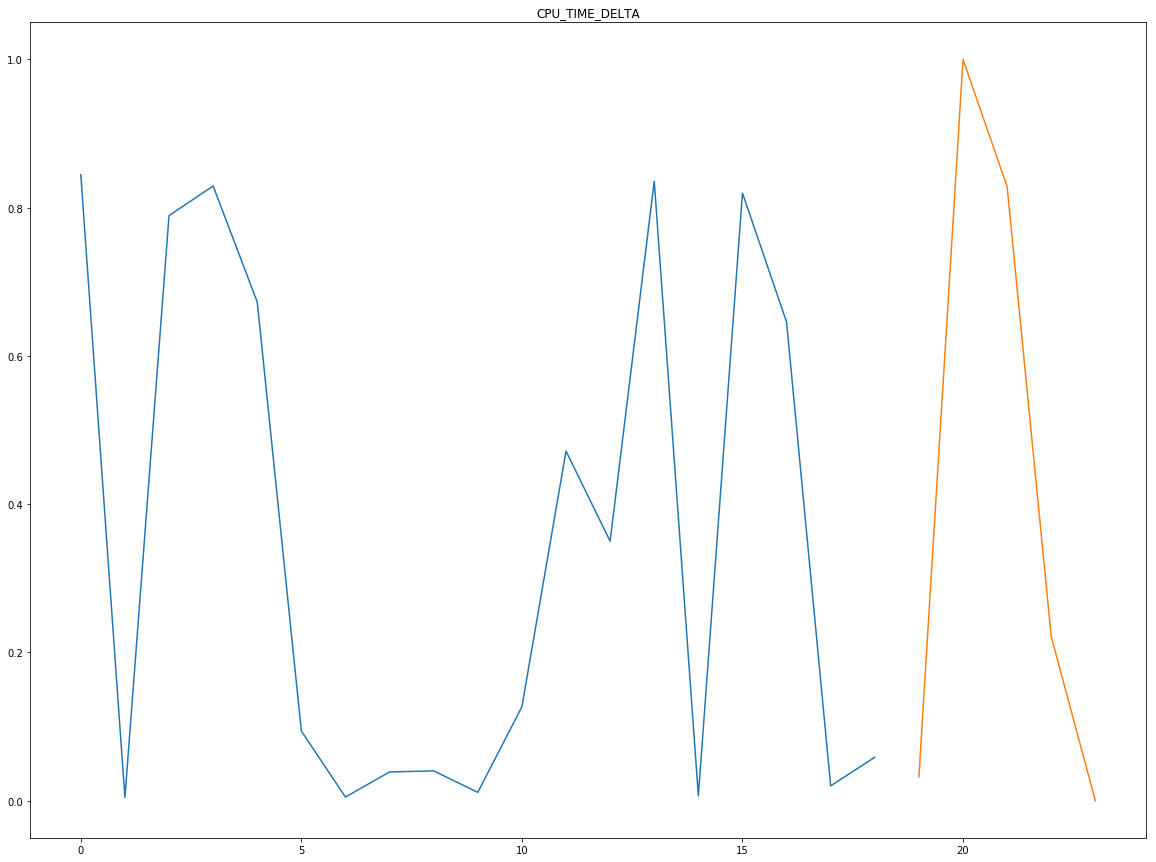

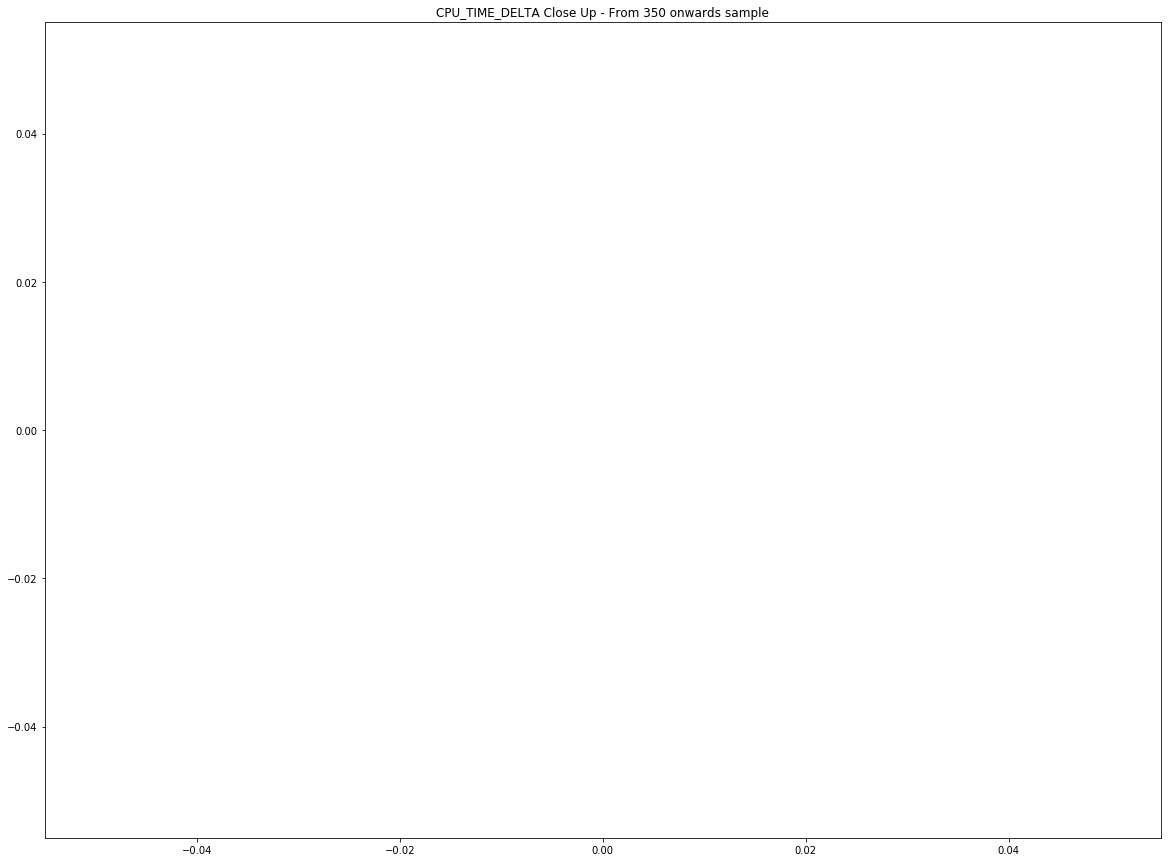

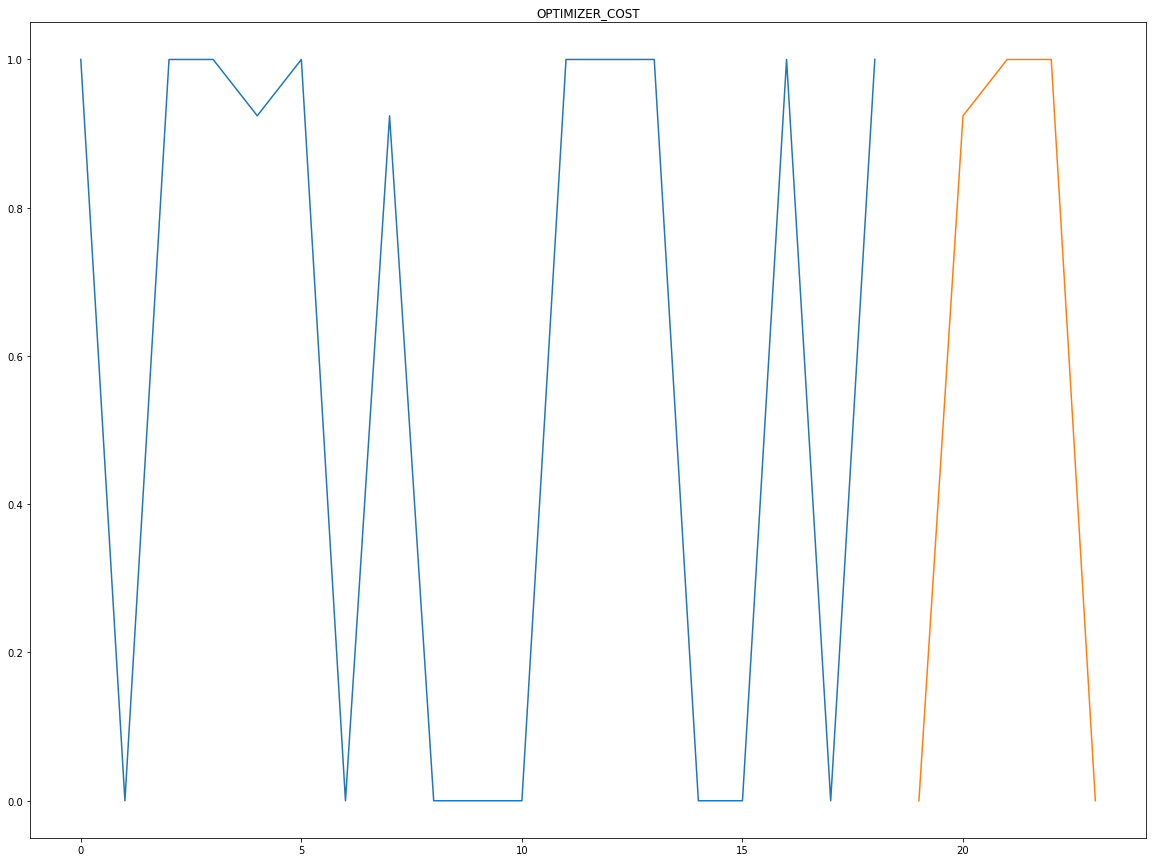

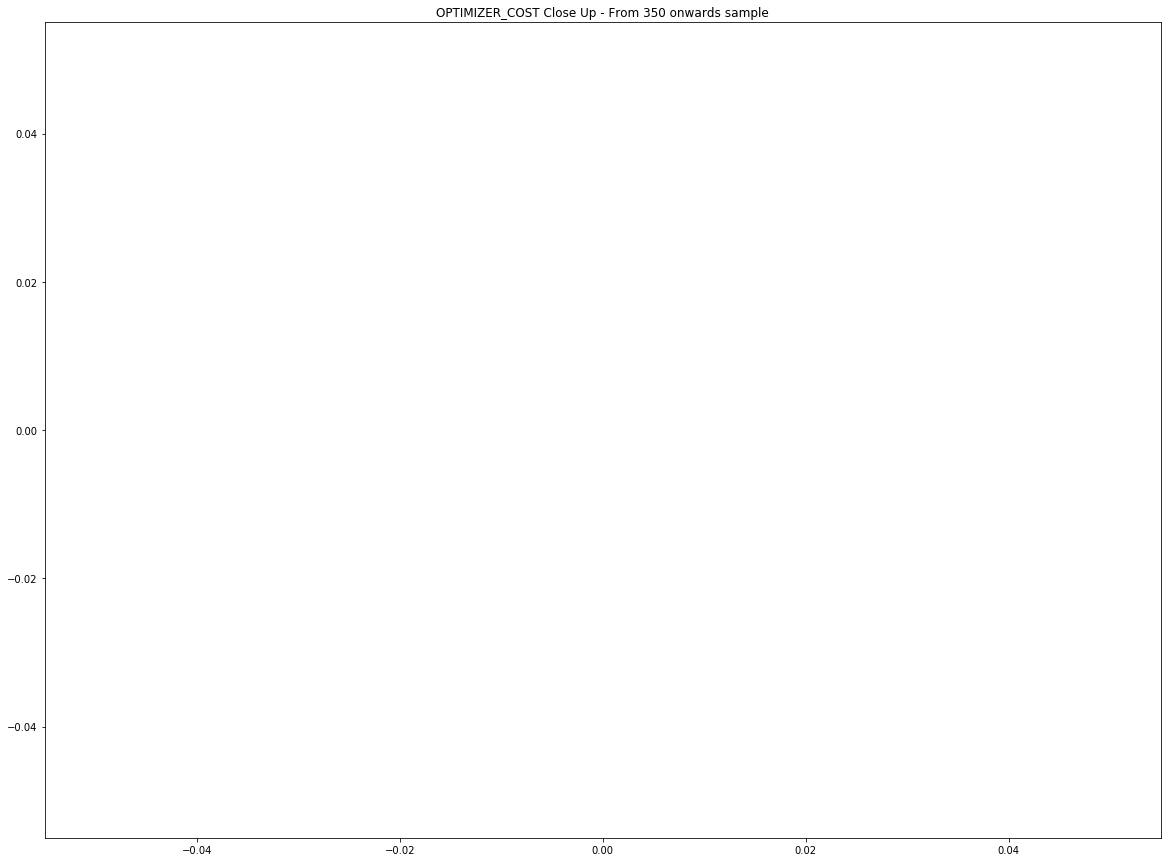

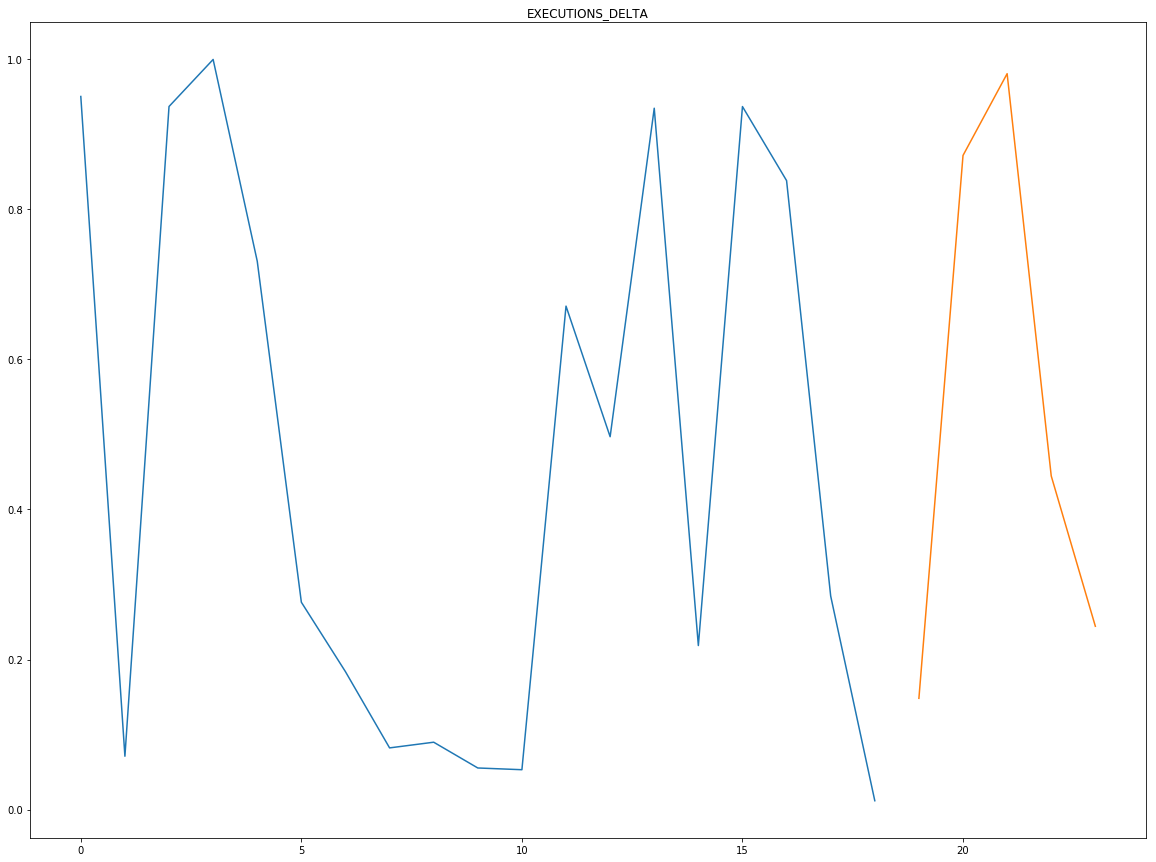

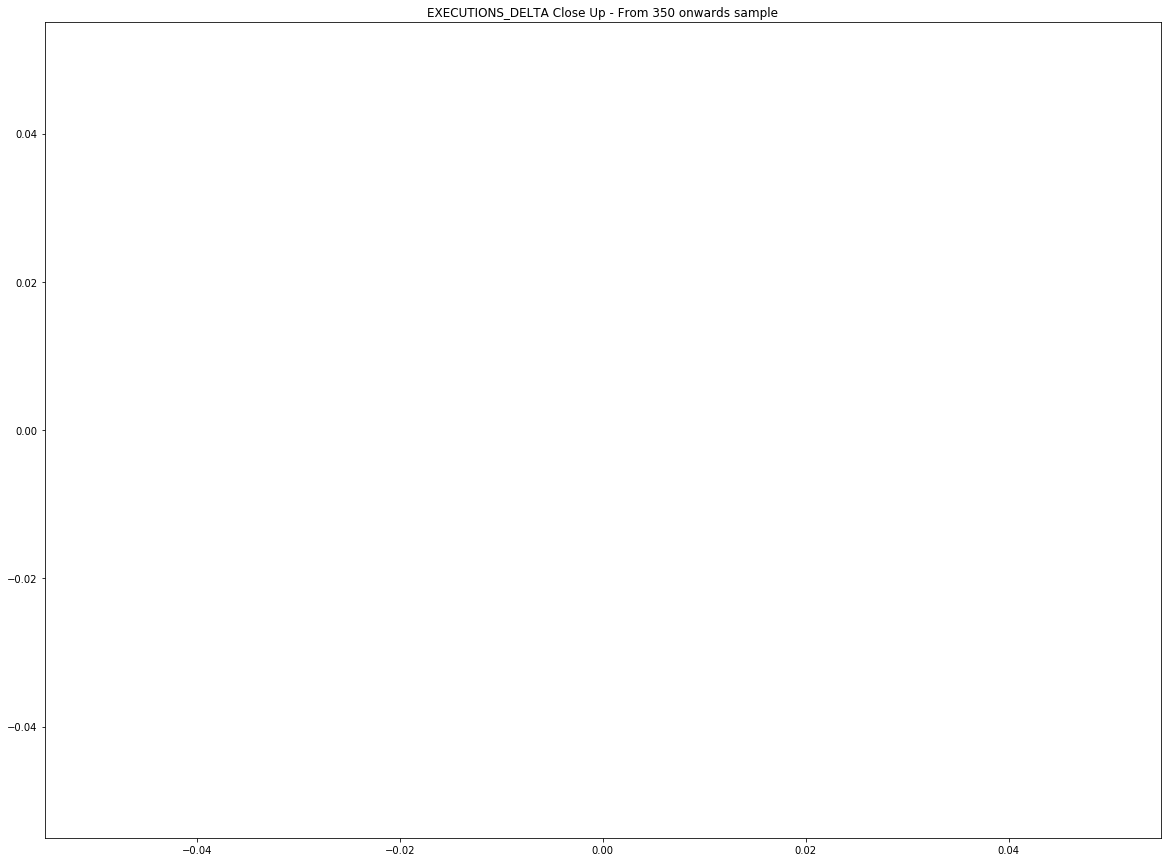

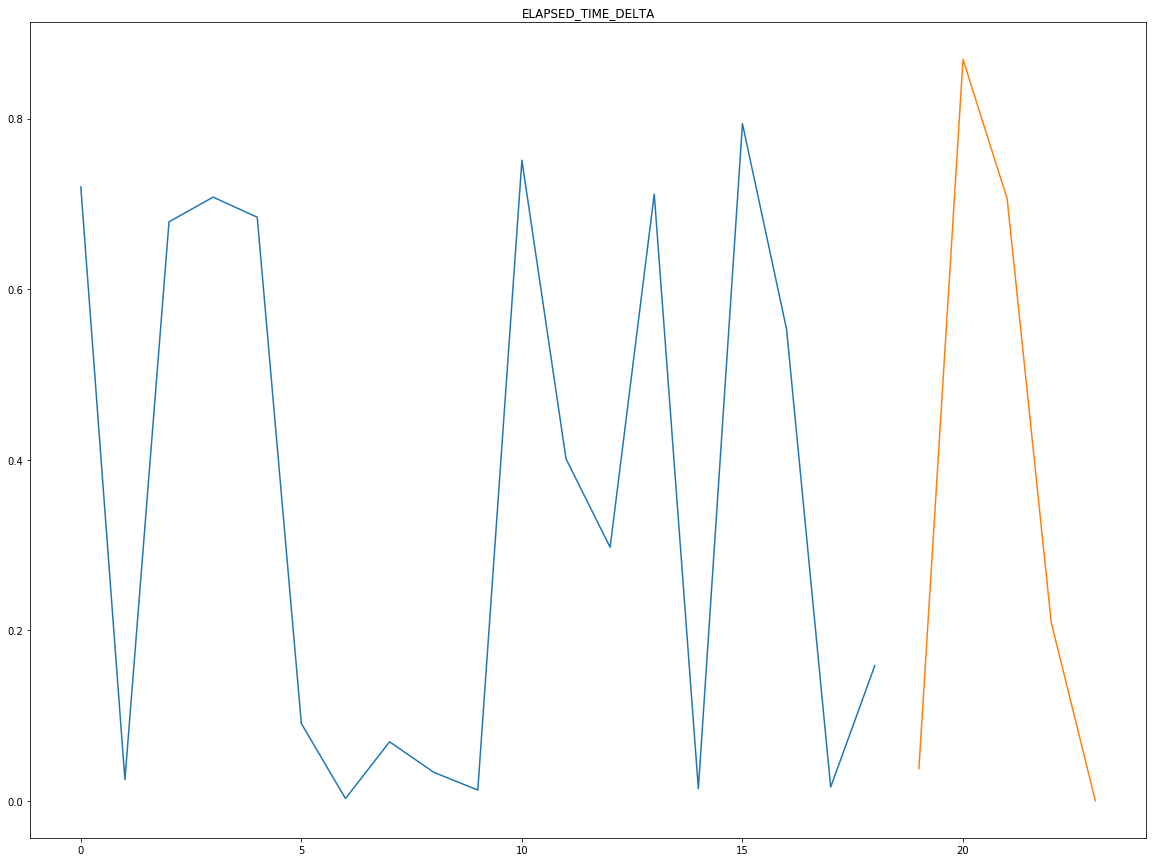

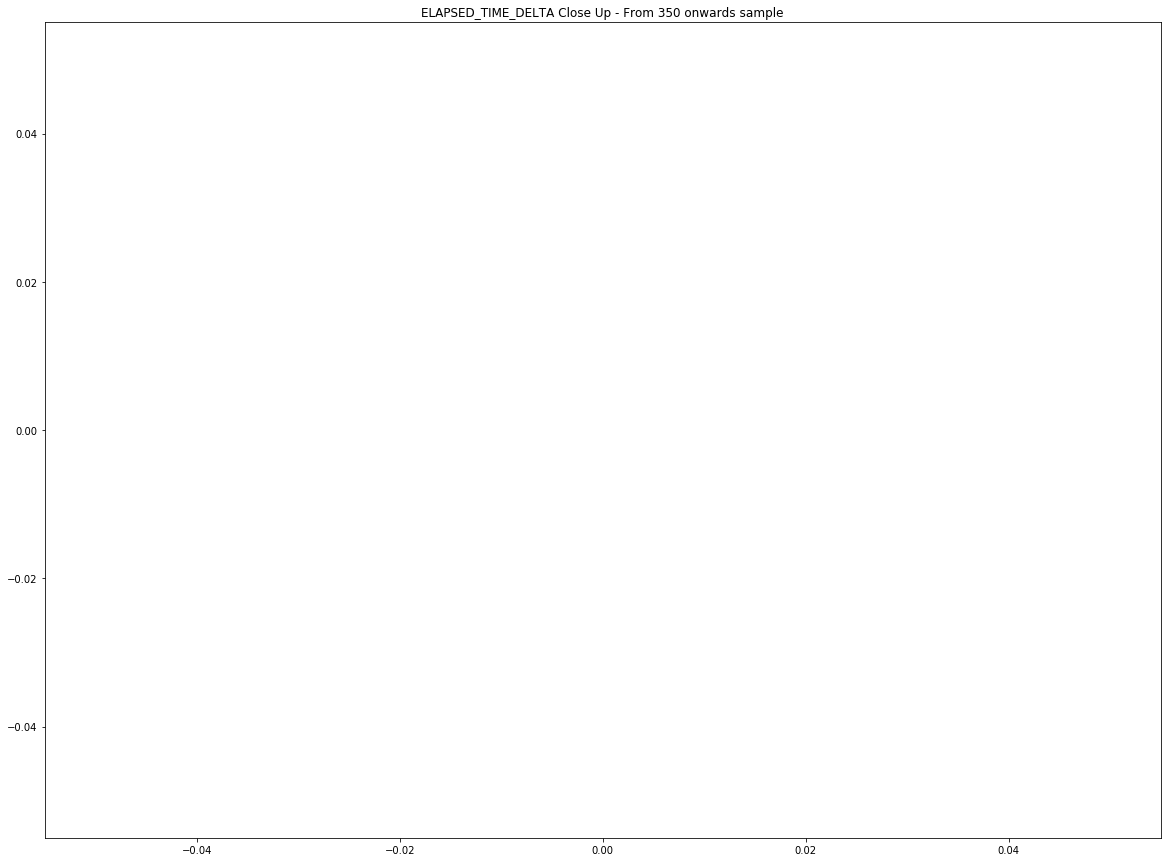

In [18]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))
#
# Plotting label over time for train, test
# print(y_train)
# print(y_train[:,0])
for i in range(0, len(y_validate[0])):
    #
    # Whole Sample
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(y_train[:,i])
    validate_and_test = list(y_validate[:,i]) + list(y_test[:,i])
    plt.plot([None for j in y_train[:,i]] + [x for x in validate_and_test])
    plt.title(y_label[i])
    plt.show()
    #
    # Sub-Sample (100 range)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot([j for j in y_train[sub_sample_start:sub_sample_start+100,i]])
    plt.title(y_label[i] + " Close Up - From " + str(sub_sample_start) + " onwards sample")
    plt.show()

### K-Means Application

The following section attempts to feed the previous pre-processed data into an unsupervised model. K-Means (++) will be used for the following experiment, with a varied number of different centroid configurations.

In [23]:
class KMeansWrapper:
    """
    A class which serves a K-Means wrapper
    """
    #
    def __init__(self, n_clusters, n_jobs, init, random_state=random_state):
        self.model = KMeans(n_clusters=n_clusters, 
                            n_jobs=n_jobs, 
                            init=init, 
                            random_state=random_state)
    #
    def fit_model(self, X):
        self.model.fit(X)
    #
    def predict(self, X):
        return self.model.predict(X)
    #
    def predict_and_evaluate(self, X, y):
        """
        f1_score, accuracy_score, precision_score, recall_score
        """
        yhat = self.predict(X)
        f1 = f1_score(y, yhat, average='micro')
        accuracy = accuracy_score(y, yhat)
        precision = precision_score(y, yhat)
        recall = recall_score(y, yhat)
        #
        print('Accuracy: ' + str(accuracy))
        print('Precision: ' + str(precision))
        print('Recall: ' + str(recall))
        print('F1-Score: ' + str(f1))
    #
    def get_labels(self):
        """
        Returns labels derived from cluster centroids
        """
        return self.model.labels_

In [24]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
y_validate = y_validate.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
#
X_test = X_test.values
y_test = y_test.values
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)) + "\n------------------------------")
#
# Map Discretize function to matrices
vecfunc = np.vectorize(discretize_value)
print(X_train[0:5])
print(y_train[0:5])
X_train=vecfunc(X_train)
y_train=vecfunc(y_train)
print(X_train[0:5])
print(y_train[0:5])
print('------------------------------------------------------------')
print(X_validate[0:5])
print(y_validate[0:5])
X_validate=vecfunc(X_validate)
y_validate=vecfunc(y_validate)
print(X_validate[0:5])
print(y_validate[0:5])
print('------------------------------------------------------------')
print(X_test[0:5])
print(y_test[0:5])
X_test=vecfunc(X_test)
y_test=vecfunc(y_test)
print(X_test[0:5])
print(y_test[0:5])
#
# Train on discrete data (Train > Validation)
model = KMeansWrapper(n_clusters=n_clusters,
                      n_jobs=n_jobs,
                      init=init,
                      random_state=random_state)
model.fit_model(X=X_train)
model.predict_and_evaluate(X=X_validate,
                           y=y_validate)

X_train shape [(19, 480)] Type - <class 'numpy.ndarray'>
y_train shape [(19, 4)] Type - <class 'numpy.ndarray'>
X_validate shape [(2, 480)] Type - <class 'numpy.ndarray'>
y_validate shape [(2, 4)] Type - <class 'numpy.ndarray'>
X_test shape [(3, 480)] Type - <class 'numpy.ndarray'>
y_test shape [(3, 4)] Type - <class 'numpy.ndarray'>
------------------------------
[[6.45731499e-01 9.99999995e-01 8.38497034e-01 ... 3.44927926e-01
  7.63183009e-01 9.99996790e-01]
 [4.97748661e-03 3.10022244e-09 1.83750824e-01 ... 4.84758360e-01
  0.00000000e+00 9.99996790e-01]
 [2.00739652e-02 3.06159038e-10 2.84607779e-01 ... 7.80861619e-01
  0.00000000e+00 9.99997478e-01]
 [8.19761060e-01 7.16525631e-07 9.37211602e-01 ... 8.53958386e-01
  3.19872902e-01 9.99999541e-01]
 [4.32296207e-03 0.00000000e+00 7.10283454e-02 ... 2.66741847e-01
  0.00000000e+00 9.99996790e-01]]
[[4.97748661e-03 3.10022244e-09 1.83750824e-01 2.57105945e-03]
 [5.86483368e-02 9.99999462e-01 1.17007251e-02 1.58472370e-01]
 [1.0000000

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets